# Chapter 3. Modeling with Linear Regressions

In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap, local_device_count

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim

from numpyro.infer import MCMC, NUTS, HMC, Predictive
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation


seed=1234

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu") # or "gpu", "tpu" depending on system
numpyro.set_host_device_count(local_device_count())

In [2]:
# import pymc3 as pm
# import numpy as np
# import pandas as pd
# from theano import shared
# import scipy.stats as stats
# import matplotlib.pyplot as plt
# import arviz as az

In [3]:
# az.style.use('arviz-darkgrid')

## Simple linear regression

In [4]:
N = 100
alpha_real = 2.5
beta_real = 0.9

eps_real = dist.Normal(loc=0, scale=1).sample(random.PRNGKey(0), (N,))

x = dist.Normal(loc=10, scale=1.).sample(random.PRNGKey(1), (N,)) # Same seed produces perfect line
y_real = alpha_real + beta_real * x
y = y_real + eps_real

# we can center the data
# x = x - x.mean()
# or standardize the data
# x = (x - x.mean())/x.std()
# y = (y - y.mean())/y.std()

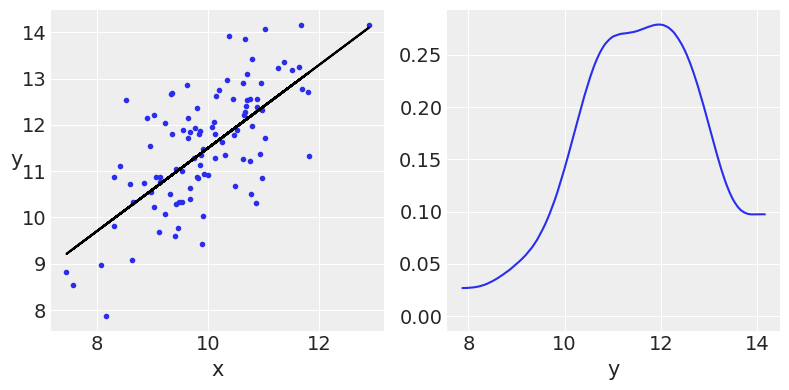

In [5]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')

az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()

In [6]:
def model(obs=None):
    α = numpyro.sample('α', dist.Normal(loc=0, scale=10))
    β = numpyro.sample('β', dist.Normal(loc=0, scale=1))
    ϵ = numpyro.sample('ϵ', dist.HalfCauchy(scale=5))
    
    μ = numpyro.deterministic('μ', α + β * x)
    
    y_pred = numpyro.sample('y_pred', dist.Normal(loc=μ, scale=ϵ), obs=obs, sample_shape=(len(y),))
        
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=2000, num_chains=2)
mcmc.run(random.PRNGKey(seed), obs=y)

sample: 100%|█████████████████████████| 3000/3000 [00:00<00:00, 6089.22it/s, 11 steps of size 6.59e-02. acc. prob=0.94]


array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

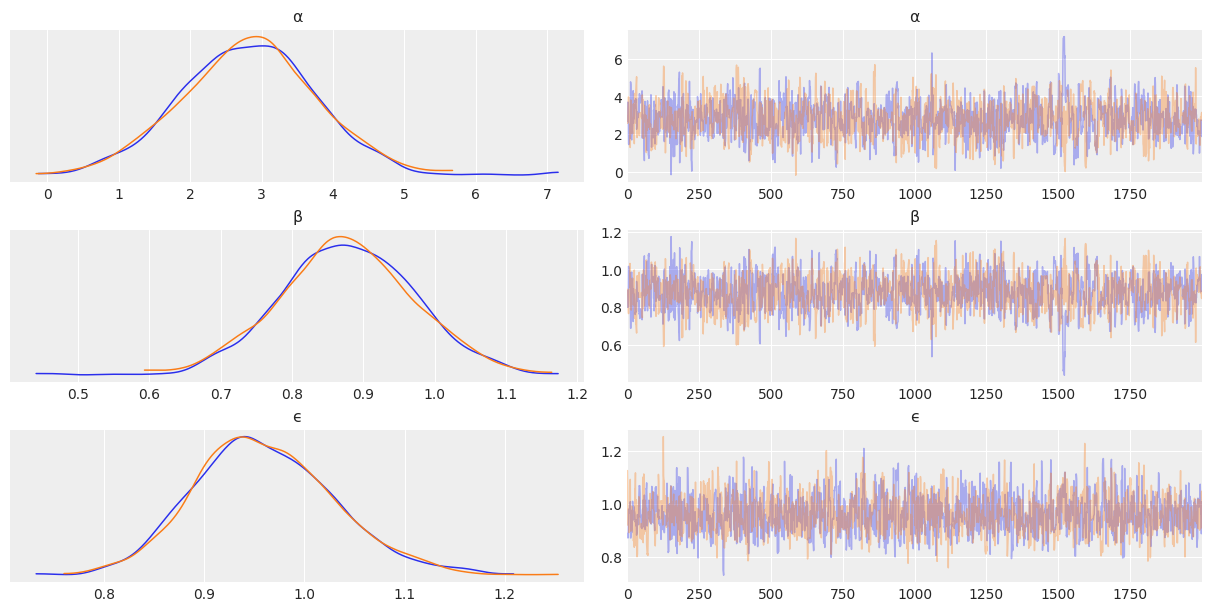

In [7]:
az.plot_trace(mcmc, var_names=['α', 'β', 'ϵ'], compact=False)

### Modyfing the data before running the models

<AxesSubplot:xlabel='α', ylabel='β'>

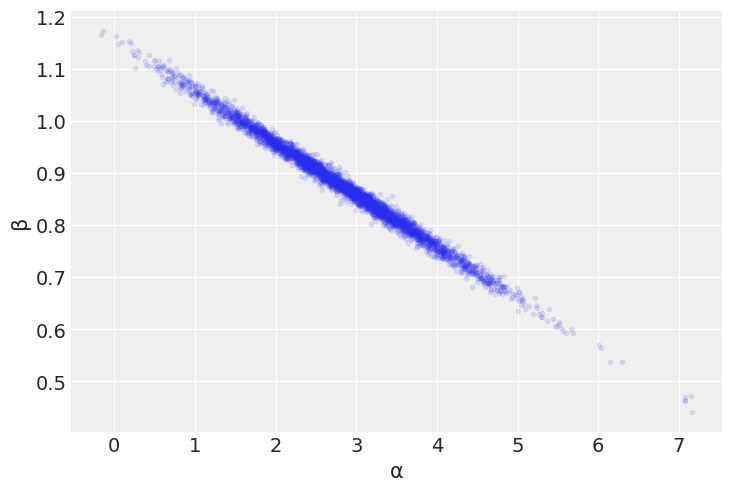

In [8]:
az.plot_pair(mcmc, var_names=['α', 'β'], scatter_kwargs={'alpha': 0.1})  # UserWarning: plot_kwargs will be deprecated. Please use scatter_kwargs, kde_kwargs and/or hexbin_kwargs

### interpreting the posterior

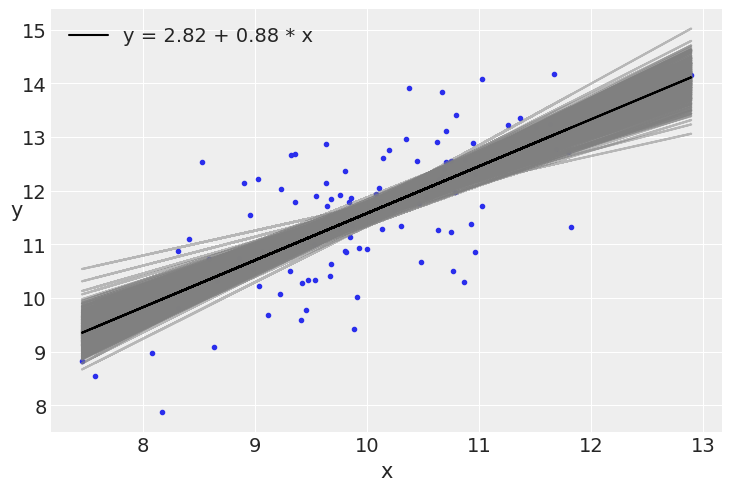

In [9]:
plt.plot(x, y, 'C0.')

alpha_m = mcmc.get_samples()['α'].mean()
beta_m = mcmc.get_samples()['β'].mean()

draws = range(0, len(mcmc.get_samples()['α']), 10)
plt.plot(x, mcmc.get_samples()['α'][jnp.array(draws)] + mcmc.get_samples()['β'][jnp.array(draws)]  # https://github.com/google/jax/issues/4564
         * x[:, jnp.newaxis], c='gray', alpha=0.5)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

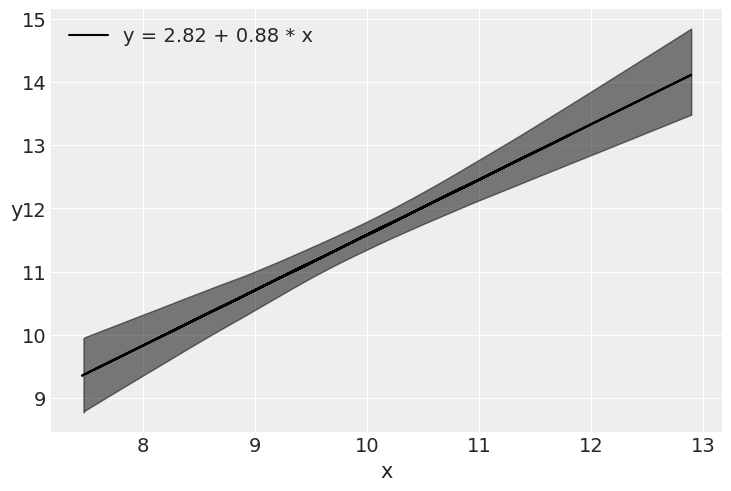

In [10]:
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

sig = az.plot_hdi(x, mcmc.get_samples()['μ'], hdi_prob=0.98, color='k')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

In [11]:
pred = Predictive(model=mcmc.sampler.model, posterior_samples=mcmc.get_samples(), return_sites=['y_pred'])
ppc = pred(random.PRNGKey(seed))

In [12]:
ppc['y_pred'].shape

(4000, 100, 100)

In [13]:
ppc['y_pred'] = ppc['y_pred'][:100]
ppc['y_pred'].shape

(100, 100, 100)

<AxesSubplot:xlabel='y_pred'>

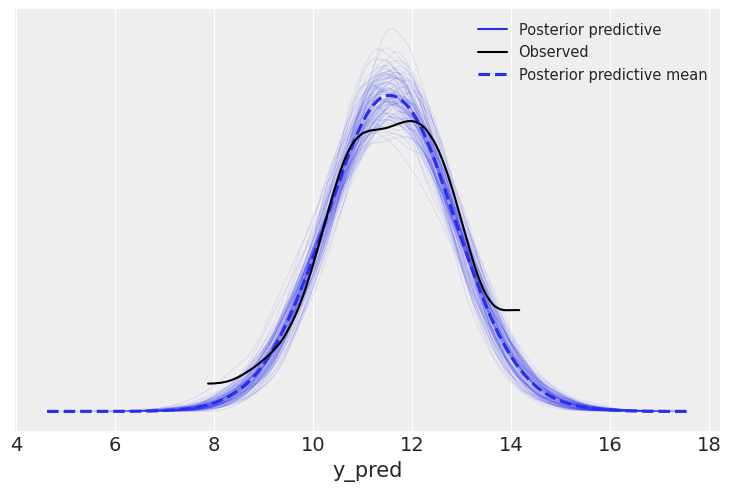

In [14]:
samples = az.from_numpyro(mcmc, posterior_predictive=ppc)
az.plot_ppc(samples, mean=True, observed=True, alpha=0.1)

Text(0, 0.5, 'y')

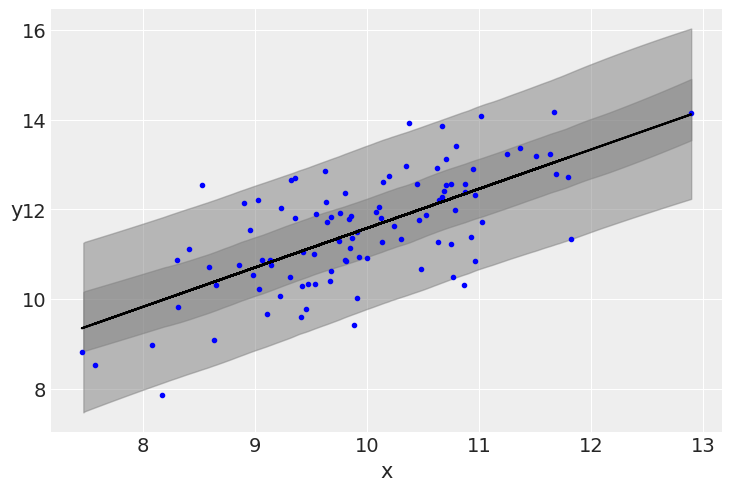

In [15]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hdi(x, ppc['y_pred'], hdi_prob=0.5, color='gray')
az.plot_hdi(x, ppc['y_pred'], color='gray')

plt.xlabel('x')
plt.ylabel('y', rotation=0)

In [16]:
az.r2_score(y, ppc['y_pred'])

r2        0.44905096
r2_std    0.03545001
dtype: object

### The multivariate normal distribution 
Actually the bivariate

Text(-0.05, 0.5, 'x_2')

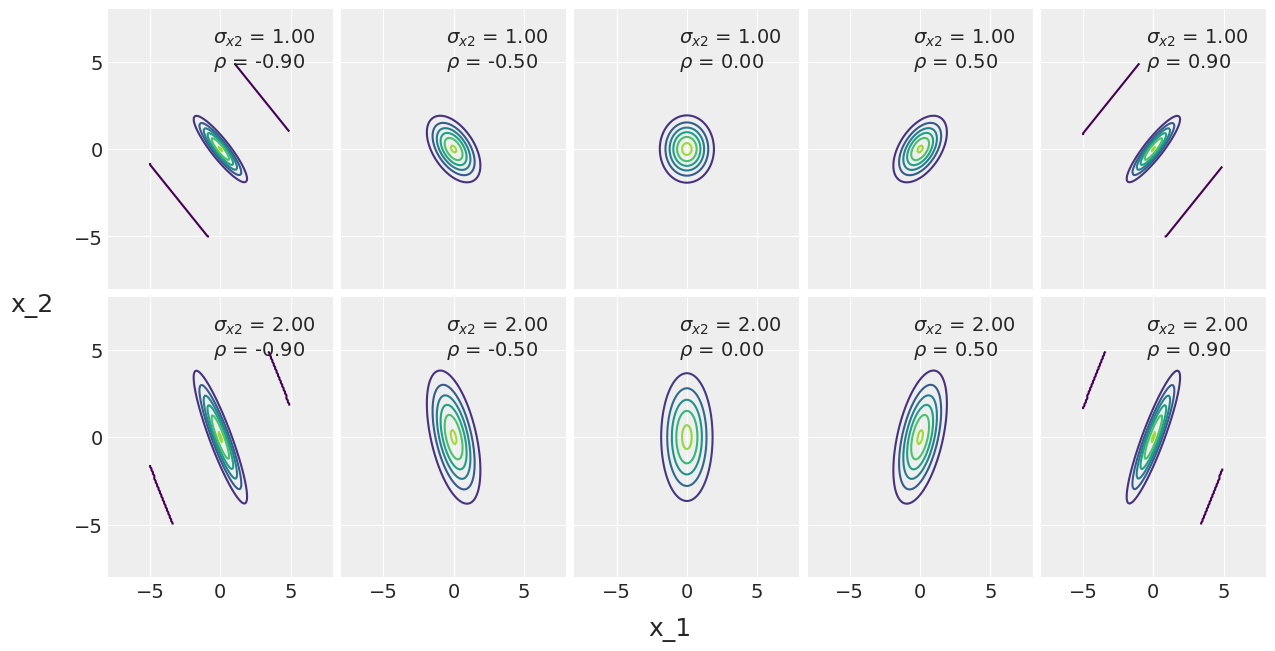

In [17]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.90, -0.5, 0, 0.5, 0.90]

k, l = jnp.mgrid[-5:5:.1, -5:5:.1]
pos = jnp.empty(k.shape + (2,))
# pos[:, :, 0] = k
# pos[:, :, 1] = l
pos = pos.at[:, :, 0].set(k)
pos = pos.at[:, :, 1].set(l)


f, ax = plt.subplots(len(sigmas_x2), len(rhos),
                     sharex=True, sharey=True, figsize=(12, 6),
                     constrained_layout=True)
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho],
               [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        
        rv = dist.MultivariateNormal(jnp.array([0,0]), covariance_matrix=cov)

        ax[i, j].contour(k, l, jnp.exp(rv.log_prob(pos)), levels=6)
        ax[i, j].set_xlim(-8, 8)
        ax[i, j].set_ylim(-8, 8)
        ax[i, j].set_yticks([-5, 0, 5])
        ax[i, j].plot(0, 0, label=f'$\\sigma_{{x2}}$ = {sigma_x2:3.2f}\n$\\rho$ = {rho:3.2f}', alpha=0)
        ax[i, j].legend()
f.text(0.5, -0.05, 'x_1', ha='center', fontsize=18)
f.text(-0.05, 0.5, 'x_2', va='center', fontsize=18, rotation=0)

In [18]:
data = jnp.stack((x, y)).T

def model(obs=None):
    
    μ = numpyro.sample('μ', dist.Normal(loc=data.mean(0), scale=10))
    
    σ_1 = numpyro.sample('σ_1', dist.HalfNormal(scale=10))
    σ_2 = numpyro.sample('σ_2', dist.HalfNormal(scale=10))
    ρ = numpyro.sample('ρ', dist.Uniform(low=-1., high=1.))
    
    r2 = numpyro.deterministic('r2', ρ**2)
    
    cov = jnp.stack((jnp.array([σ_1**2, σ_1*σ_2*ρ]),
                    jnp.array([σ_1*σ_2*ρ, σ_2**2])))
    
    y_pred = numpyro.sample('y_pred', dist.MultivariateNormal(loc=μ, covariance_matrix=cov), obs=obs)
    
kernel = NUTS(model)
mcmc2 = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
mcmc2.run(random.PRNGKey(seed), obs=data)

sample: 100%|██████████████████████████| 2000/2000 [00:00<00:00, 5375.78it/s, 7 steps of size 5.08e-01. acc. prob=0.91]


array([[<AxesSubplot:title={'center':'r2'}>,
        <AxesSubplot:title={'center':'r2'}>]], dtype=object)

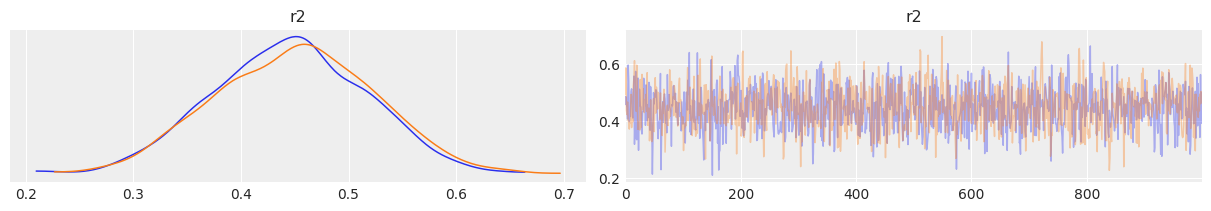

In [19]:
az.plot_trace(mcmc2, var_names=['r2'], compact=False)

In [20]:
az.summary(mcmc2, var_names=['r2'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r2,0.447,0.074,0.309,0.581,0.002,0.001,1528.0,1405.0,1.0


## Robust linear regression

In [21]:
ans = pd.read_csv('../data/anscombe.csv')
x_3 = ans[ans.group == 'III']['x'].values
y_3 = ans[ans.group == 'III']['y'].values
x_3 = x_3 - x_3.mean()

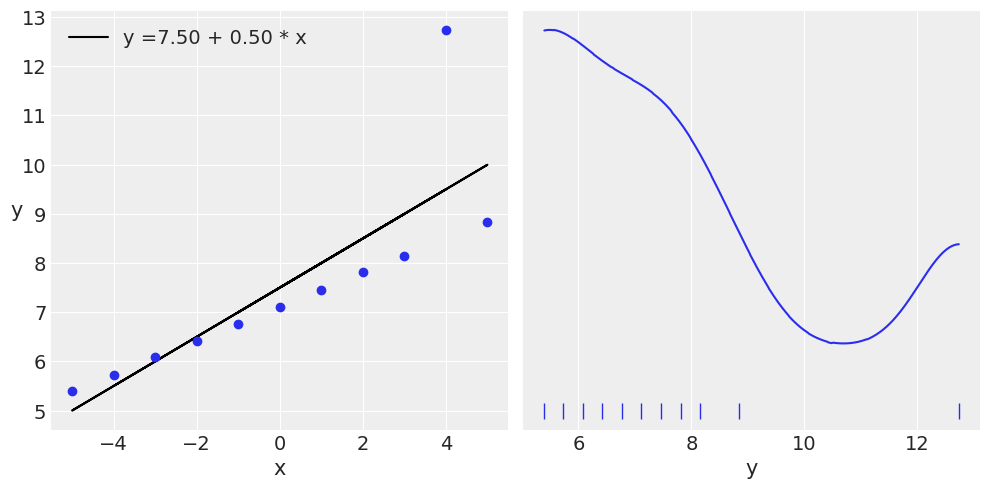

In [22]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
beta_c, alpha_c = jnp.polyfit(x_3, y_3, deg=1) # equivulant to stats.linregress(x_3, y_3)[:2]
ax[0].plot(x_3, (alpha_c + beta_c * x_3), 'k',
           label=f'y ={alpha_c:.2f} + {beta_c:.2f} * x')
ax[0].plot(x_3, y_3, 'C0o')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].legend(loc=0)
az.plot_kde(y_3, ax=ax[1], rug=True)
ax[1].set_xlabel('y')
ax[1].set_yticks([])
plt.tight_layout()

In [23]:
def model(obs=None):
    α = numpyro.sample('α', dist.Normal(loc=y_3.mean(), scale=1))
    β = numpyro.sample('β', dist.Normal(loc=0, scale=1))
    ϵ = numpyro.sample('ϵ', dist.HalfNormal(scale=5))
    ν_ = numpyro.sample('ν_', dist.Exponential(rate=1/29))
    ν = numpyro.deterministic('ν', ν_ + 1)

    y_pred = numpyro.sample('y_pred', dist.StudentT(df=ν, loc=α + β * x_3, scale=ϵ), obs=obs)
    
kernel = NUTS(model)
mcmc3 = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=4)
mcmc3.run(random.PRNGKey(seed), obs=y_3)

sample: 100%|█████████████████████████| 2000/2000 [00:00<00:00, 3796.61it/s, 15 steps of size 1.06e-01. acc. prob=0.81]


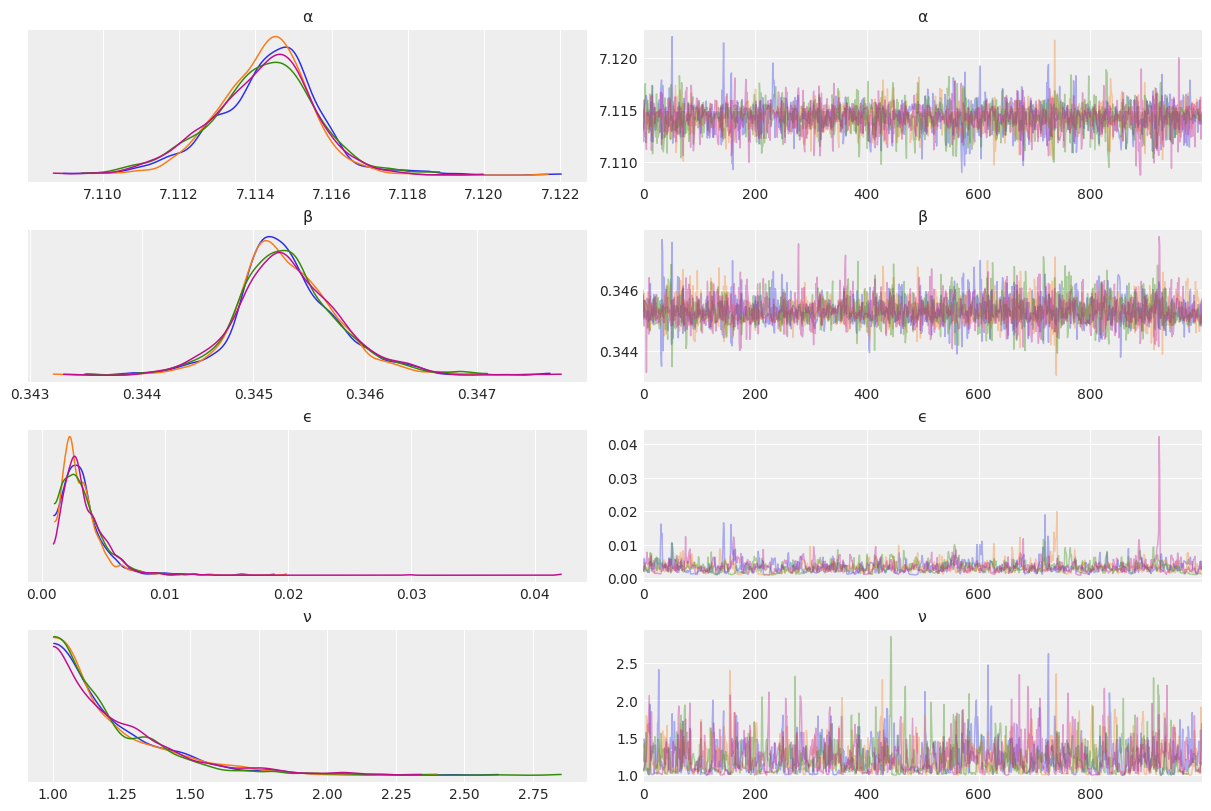

In [24]:
varnames = ['α', 'β', 'ϵ', 'ν']
az.plot_trace(mcmc3, var_names=varnames, compact=False);

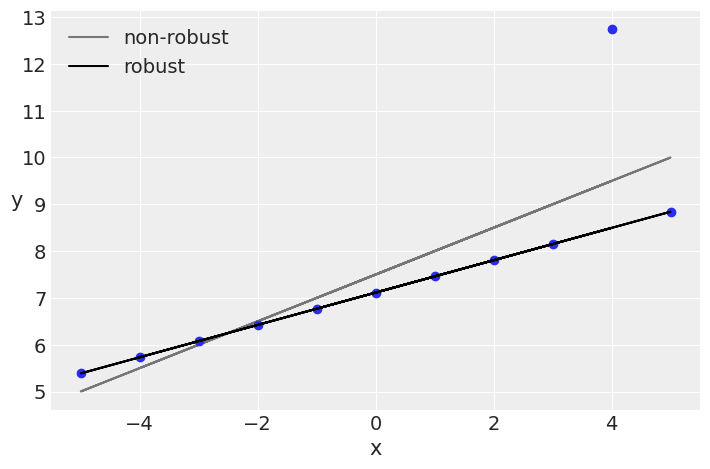

In [25]:
beta_c, alpha_c = jnp.polyfit(x_3, y_3, deg=1) 

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = jnp.mean(mcmc3.get_samples()['α'])
beta_m = jnp.mean(mcmc3.get_samples()['β'])
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend(loc=2)
plt.tight_layout()

In [26]:
az.summary(mcmc3, var_names=varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,7.114,0.001,7.112,7.117,0.000,0.000,3155.0,2179.0,1.00
β,0.345,0.000,0.345,0.346,0.000,0.000,3861.0,2209.0,1.00
ϵ,0.003,0.002,0.001,0.006,0.000,0.000,402.0,327.0,1.01
ν,1.219,0.214,1.000,1.604,0.006,0.004,906.0,847.0,1.00


In [27]:
pred = Predictive(model=mcmc3.sampler.model, posterior_samples=mcmc3.get_samples(), return_sites=['y_pred'])
ppc = pred(random.PRNGKey(seed))

In [28]:
ppc['y_pred'] = ppc['y_pred'][:200]
ppc['y_pred'].shape

(200, 11)

(0.0, 12.0)

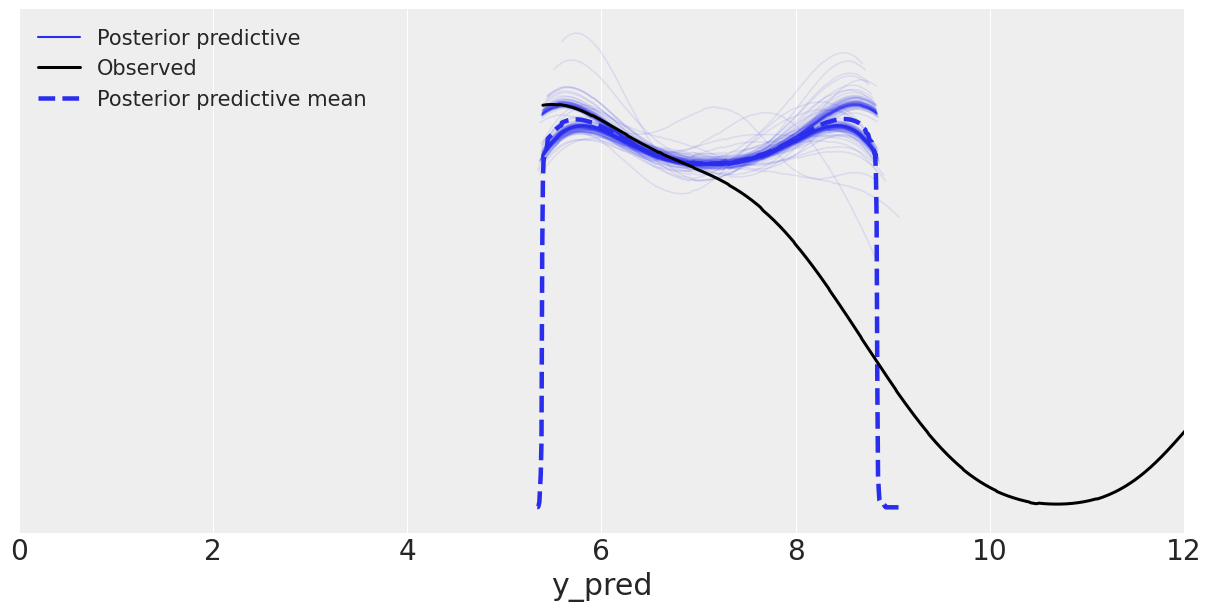

In [29]:
data_ppc = az.from_numpyro(mcmc3, posterior_predictive=ppc)
az.plot_ppc(data_ppc, figsize=(12, 6), mean=True, alpha=0.1, color='C0')
plt.xlim(0, 12)

## Hierarchical linear regression

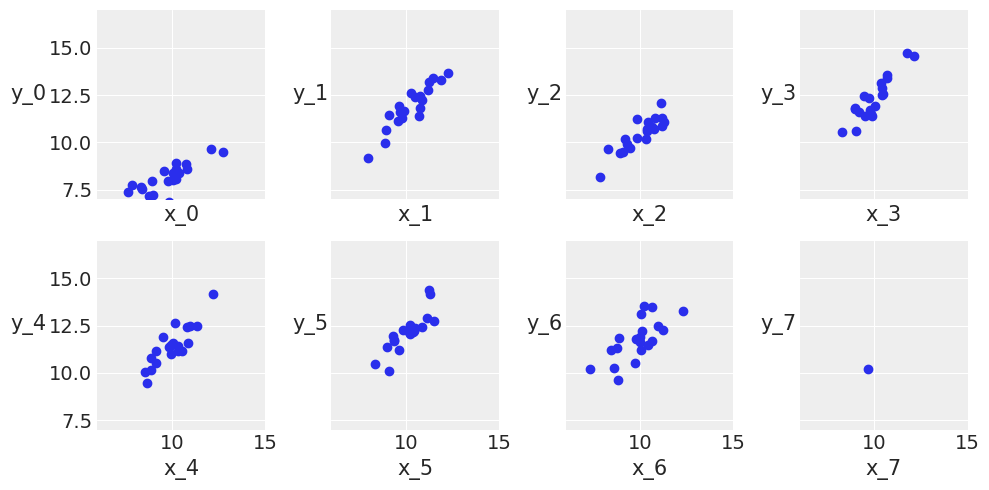

In [30]:
N = 20
M = 8
idx = jnp.repeat(jnp.arange(M-1), N)
idx = jnp.append(idx, 7)

# alpha_real = numpyro.sample('alpha_real', dist.Normal(loc=2.5, scale=0.5), sample_shape=(M,)) 
alpha_real = dist.Normal(loc=2.5, scale=0.5).sample(random.PRNGKey(seed), (M,))
beta_real = dist.Beta(concentration1=6, concentration0=1).sample(random.PRNGKey(seed), (M,))
eps_real = dist.Normal(loc=0, scale=0.5).sample(random.PRNGKey(seed+1), (len(idx),))
                                                
y_m = jnp.zeros(len(idx))
x_m = dist.Normal(loc=10, scale=1.).sample(random.PRNGKey(seed), (len(idx),))
                                           
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True)
ax = list(ax.flat) # np.ravel(ax)
j, k = 0, N
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', rotation=0, labelpad=15)
    ax[i].set_xlim(6, 15)
    ax[i].set_ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

In [32]:
x_centered = x_m - x_m.mean()

In [ ]:
with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10, shape=M)
    β = pm.Normal('β', mu=0, sd=10, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())

    trace_up = pm.sample(2000)

In [ ]:
az.plot_forest(trace_up, var_names=['α', 'β'], combined=True)
plt.savefig('B11197_03_14.png', dpi=300)

<img src='./imgs/B11197_03_15.png' width="700">

In [ ]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sd=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10)
    β_μ = pm.Normal('β_μ', mu=0, sd=10)
    β_σ = pm.HalfNormal('β_σ', sd=10)

    # priors
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    trace_hm = pm.sample(1000)

In [ ]:
az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True)
plt.savefig('B11197_03_16.png', dpi=300)

In [ ]:
_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
                     constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hm['α'][:, i].mean()
    beta_m = trace_hm['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.savefig('B11197_03_17.png', dpi=300)

## Polynomial regression

In [ ]:
x_2 = ans[ans.group == 'II']['x'].values
y_2 = ans[ans.group == 'II']['y'].values
x_2 = x_2 - x_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_18.png', dpi=300)

In [ ]:
with pm.Model() as model_poly:
    α = pm.Normal('α', mu=y_2.mean(), sd=1)
    β1 = pm.Normal('β1', mu=0, sd=1)
    β2 = pm.Normal('β2', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    mu = α + β1 * x_2 + β2 * x_2**2

    y_pred = pm.Normal('y_pred', mu=mu, sd=ϵ, observed=y_2)

    trace_poly = pm.sample(2000)

In [ ]:
#az.plot_trace(trace_poly);

In [ ]:
#az.summary(trace_poly)

In [ ]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['α'].mean() + trace_poly['β1'].mean() * \
    x_p + trace_poly['β2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.plot(x_p, y_p, c='C1')
plt.savefig('B11197_03_19.png', dpi=300)

## Multiple Linear regression

In [ ]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

In [ ]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)

scatter_plot(X_centered, y)
plt.savefig('B11197_03_20.png', dpi=300)

In [ ]:
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α_tmp + pm.math.dot(X_centered, β)

    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_mlr = pm.sample(2000)

In [ ]:
varnames = ['α', 'β', 'ϵ']
#az.plot_trace(trace_mlr, var_names=varnames);

In [ ]:
az.summary(trace_mlr, var_names=varnames)

## Confounding variables and redundant variables

In [ ]:
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

In [ ]:
scatter_plot(X, y)
plt.savefig('B11197_03_21.png', dpi=300)

In [ ]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0] + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1x2 = pm.sample(2000)


with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1 = pm.sample(2000)

with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x2 = pm.sample(2000)

In [ ]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=False, colors='cycle', figsize=(8, 3))
plt.savefig('B11197_03_22.png', dpi=300)

In [ ]:
# just repeating the code from a couple of cells before, but with a lower value of `scale`.
np.random.seed(42)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2)).T

In [ ]:
scatter_plot(X, y)
plt.savefig('B11197_03_23.png', dpi=300)

In [ ]:
with pm.Model() as model_red:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=10, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + pm.math.dot(X, β)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_red = pm.sample(2000)

In [ ]:
az.plot_forest(trace_red, var_names=['β'], combined=True, figsize=(8, 2))
plt.savefig('B11197_03_24.png', dpi=300)

In [ ]:
az.plot_pair(trace_red, var_names=['β'])
plt.savefig('B11197_03_25.png', dpi=300)

## Masking effect variables

In [ ]:
np.random.seed(42)
N = 126
r = 0.8
x_1 = np.random.normal(size=N)
x_2 = np.random.normal(x_1, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(x_1 - x_2)
X = np.vstack((x_1, x_2)).T

In [ ]:
scatter_plot(X, y)
plt.savefig('B11197_03_26.png', dpi=300, figsize=(5.5, 5.5))

In [ ]:
with pm.Model() as m_x1x2:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0] + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1x2 = pm.sample(1000)


with pm.Model() as m_x1:
    α = pm.Normal('α', mu=0, sd=10)
    β1 = pm.Normal('β1', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β1 * X[:, 0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x1 = pm.sample(1000)

with pm.Model() as m_x2:
    α = pm.Normal('α', mu=0, sd=10)
    β2 = pm.Normal('β2', mu=0, sd=10)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α + β2 * X[:, 1]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_x2 = pm.sample(1000)

In [ ]:
az.plot_forest([trace_x1x2, trace_x1, trace_x2],
               model_names=['m_x1x2', 'm_x1', 'm_x2'],
               var_names=['β1', 'β2'],
               combined=True, colors='cycle', figsize=(8, 3))
plt.savefig('B11197_03_27.png', dpi=300, bbox_inches='tight')

## Variable variance

In [ ]:
data = pd.read_csv('../data/babies.csv')
data.plot.scatter('Month', 'Lenght')
plt.savefig('B11197_03_28.png', dpi=300)

In [ ]:
with pm.Model() as model_vv:
    α = pm.Normal('α', sd=10)
    β = pm.Normal('β', sd=10)
    γ = pm.HalfNormal('γ', sd=10)
    δ = pm.HalfNormal('δ', sd=10)

    x_shared = shared(data.Month.values * 1.)

    μ = pm.Deterministic('μ', α + β * x_shared**0.5)
    ϵ = pm.Deterministic('ϵ', γ + δ * x_shared)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=data.Lenght)

    trace_vv = pm.sample(1000, tune=1000)

In [ ]:
plt.plot(data.Month, data.Lenght, 'C0.', alpha=0.1)

μ_m = trace_vv['μ'].mean(0)
ϵ_m = trace_vv['ϵ'].mean(0)

plt.plot(data.Month, μ_m, c='k')
plt.fill_between(data.Month, μ_m + 1 * ϵ_m, μ_m -
                 1 * ϵ_m, alpha=0.6, color='C1')
plt.fill_between(data.Month, μ_m + 2 * ϵ_m, μ_m -
                 2 * ϵ_m, alpha=0.4, color='C1')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_03_29.png', dpi=300)

In [ ]:
x_shared.set_value([0.5])
ppc = pm.sample_posterior_predictive(trace_vv, 2000, model=model_vv)
y_ppc = ppc['y_pred'][:, 0]

In [ ]:
ref = 53
density, l, u = az._fast_kde(y_ppc)
x_ = np.linspace(l, u, 200)
plt.plot(x_, density)
percentile = int(sum(y_ppc <= ref) / len(y_ppc) * 100)
plt.fill_between(x_[x_ < ref], density[x_ < ref],
                 label='percentile = {:2d}'.format(percentile))
plt.xlabel('length')
plt.yticks([])
plt.legend()
plt.savefig('B11197_03_30.png', dpi=300)

In [ ]:
x_4 = ans[ans.group == 'IV']['x'].values
y_4 = ans[ans.group == 'IV']['y'].values

with pm.Model() as model_t2:
    α = pm.Normal('α', mu=0, sd=100)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)
    #ν = pm.Gamma('ν', mu=20, sd=15)
    #ν = pm.Gamma('ν', 2, 0.1)

    y_pred = pm.StudentT('y_pred', mu=α + β * x_4, sd=ϵ, nu=ν, observed=y_4)
    trace_t2 = pm.sample(2000)